In [2]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


#data = sc.textFile("dataset.csv").map(lambda line:
#line.split(",")).map(lambda record: (record[0], record[1]))

raw_data = spark.read.csv(path='data/dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

In [3]:
#Tokennize the TrainData
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#determing components to be removed in the URL
add_stopWords = ["http", "https", "www"]

#Removing the stop words  from the tokenized data
stopwordsRemover = StopWordsRemover(inputCol=regexTokenizer.getOutputCol(), outputCol="Filtered").setStopWords(add_stopWords)

#Convert the words to ngrams
ngram = NGram(n=2, inputCol=stopwordsRemover.getOutputCol(), outputCol="Ngrams")

#Hashing the data
hashingTF = HashingTF(inputCol=stopwordsRemover.getOutputCol(), outputCol="rawFeatures")

idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features") 

countVectors = CountVectorizer(inputCol=stopwordsRemover.getOutputCol(), outputCol="features", vocabSize=10000, minDF=5)

#creating the pipepline of steps to be performed in oreder
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover,countVectors])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(raw_data)

#Transform the pipeline to dataset
dataset = pipelineFit.transform(raw_data)

#randomly split the dataset to traning and testing 70%, 30% respectively
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))



Training Dataset Count: 5000
Test Dataset Count: 2005


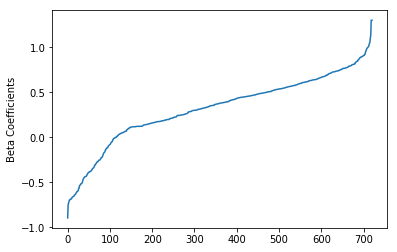

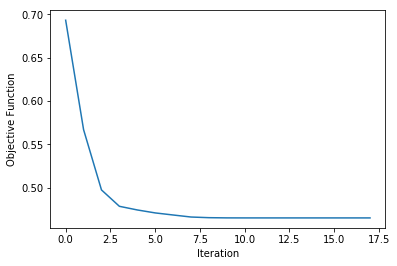

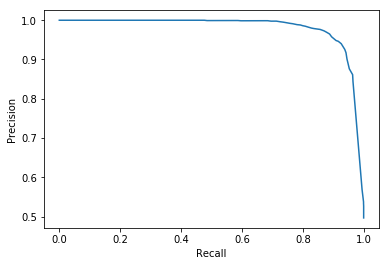

+----------------------------------------------------------------------------------------------------+-----+----------+
|                                                                                                 url|label|prediction|
+----------------------------------------------------------------------------------------------------+-----+----------+
|                                                                ftp://ftp.cs.utexas.edu/pub/garbage/|    0|       1.0|
|                                                    http://03fabe6.netsolhost.com/Dropbox/index.html|    1|       1.0|
|                                       http://0947.kontosicherheit.gdn/signin.php?email=abuse@gmx.de|    1|       1.0|
|                                      http://0c47348b.ngrok.io/109/c5ad7f54a246335bc5fc099420d31c05/|    1|       1.0|
|                                                              http://1021000.at.ua/notification.html|    1|       1.0|
|                                       

In [8]:
#==============[ LOGISTIC REGRESSION ]=========================

# Build logistic regresssion model
lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")

# Train model using logisitic regression
lrModel = lr.fit(trainingData)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Doing the prediction using test data
#Label is not used in test data
predictions = lrModel.transform(testData)

predictions.select("url", "label", "prediction").show(n=10, truncate = 100)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("\nAccuracy on Test Data = %g" % (accuracy*100))

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
#print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#predictions.filter(predictions['prediction'] == 0) \
#    .select("url", "label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 80)

In [9]:
#==============[ RANDOM FOREST ]=========================

rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

#Train model using random forest
rfModel = rf.fit(trainingData)

#Doing the prediction using test data
#Label is not used in test data
predictions = rfModel.transform(testData)

predictions.select("url", "label", "prediction").show(n=10, truncate = 100)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# Evaluate model
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("\nAccuracy on Test Data = %g" % (accuracy*100))

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
#print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#predictions.filter(predictions['prediction'] == 0) \
#    .select("url", "label","prediction") \
#    .orderBy("probability", ascending=False) \
#    .show(n = 10, truncate = 80)

+----------------------------------------------------------------------------------------------------+-----+----------+
|                                                                                                 url|label|prediction|
+----------------------------------------------------------------------------------------------------+-----+----------+
|                                                                ftp://ftp.cs.utexas.edu/pub/garbage/|    0|       0.0|
|                                                    http://03fabe6.netsolhost.com/Dropbox/index.html|    1|       1.0|
|                                       http://0947.kontosicherheit.gdn/signin.php?email=abuse@gmx.de|    1|       1.0|
|                                      http://0c47348b.ngrok.io/109/c5ad7f54a246335bc5fc099420d31c05/|    1|       0.0|
|                                                              http://1021000.at.ua/notification.html|    1|       0.0|
|                                       